<h1><center>Sepsis Prediction</h1>
<h4>TCSS 555<br>
Spring 2018<br>
Thuan Lam, Tood Robbins, Inno Irving Estrera</h4></center>


<h2>Libraries</h2>

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.utils import shuffle
from dateutil.parser import parse
from datetime import datetime

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

## User specific settings

In [124]:
import os 
cwd = os.getcwd()
print('Current folder is {}'.format(cwd))

if os.name == "posix":
    USER_DIR = '/Users/innoestrera/Desktop/mimic3/';
else:
    USER_DIR = 'C:\mimic3\\';
print(USER_DIR)

Current folder is /Users/innoestrera/repositories/Project-3-Sepsis
/Users/innoestrera/Desktop/mimic3/


## Data

In [125]:
# Load datasets
admissions = pd.read_csv("{}ADMISSIONS.csv".format(USER_DIR))[['HADM_ID','SUBJECT_ID']]
drugs = pd.read_csv("{}DRGCODES.csv".format(USER_DIR))[['HADM_ID','SUBJECT_ID','DRG_CODE','DESCRIPTION']]
stays = pd.read_csv("{}NEW_ICUSTAYS.csv".format(USER_DIR))[['HADM_ID','ICUSTAY_ID','LOS']]
chart = pd.read_csv("{}NEW_CHARTEVENTS.csv".format(USER_DIR))
patients = pd.read_csv("{}PATIENTS.csv".format(USER_DIR))
# labitems = pd.read_csv("{}D_LABITEMS.csv".format(USER_DIR))
# labevents = pd.read_csv("{}LABEVENTS.csv".format(USER_DIR), nrows=5)
# microbiologyevents = pd.read_csv("{}MICROBIOLOGYEVENTS.csv".format(USER_DIR), nrows=5)
# callout = pd.read_csv("{}CALLOUT.csv".format(USER_DIR), nrows=5)
# dcpt = pd.read_csv("{}D_CPT.csv".format(USER_DIR), nrows=5)

In [126]:
# add all datasets to array
datasets = {
    'admissions': admissions,
    'drugs': drugs,
    'stays': stays,
    'chart': chart,
    'patients': patients,
#     'labitems': labitems
#     'labevents': labevents,
#     'microbiologyevents': microbiologyevents,
#     'callout': callout,
#     'dcpt': dcpt
}

# remove unimportant itemID features from chart events
# (after running first try, these items returned 0 in feature importance section)
chart = chart[chart.ITEMID != 490]
chart = chart[chart.ITEMID != 1525]
chart = chart[chart.ITEMID != 2981]
chart = chart[chart.ITEMID != 227010]
chart = chart[chart.ITEMID != 227023]
chart = chart[chart.ITEMID != 438]

featuredItemIDs = [220615, 225690, 198, 828, 226755]

In [127]:
for csv in datasets:
    print('{}: \n\t{}'.format(csv, datasets[csv].columns.values))
# print(datasets['admissions'].columns.values)

admissions: 
	['HADM_ID' 'SUBJECT_ID']
drugs: 
	['HADM_ID' 'SUBJECT_ID' 'DRG_CODE' 'DESCRIPTION']
stays: 
	['HADM_ID' 'ICUSTAY_ID' 'LOS']
chart: 
	['ICUSTAY_ID' 'ITEMID' 'VALUE']
patients: 
	['ROW_ID' 'SUBJECT_ID' 'GENDER' 'DOB' 'DOD' 'DOD_HOSP' 'DOD_SSN'
 'EXPIRE_FLAG']


## Create the Y Set

In [128]:
#get a copy with 2 columns only
sepsis = drugs[['HADM_ID', 'DRG_CODE']].copy()

#change drug code 870, 871, 872 to 1; Otherwise, 0
#https://www.icd10monitor.com/understanding-sepsis-an-example-of-the-convergence-of-clinical-quality-coding-reimbursement-and-audit
sepsis['DRG_CODE'] = sepsis['DRG_CODE'].apply(lambda x: 1 if (x >= 870 and x <= 872) or (x >= 867 and x <= 869) or x == 776 or (x >= 974 and x <= 976) else 0)

#sum all drugcodes grouup by HADM_ID. If the sum > 0 means HADM_ID has/had sepsis
sepsis = sepsis.groupby(['HADM_ID']).sum().reset_index() # .sort_values(by=['DRG_CODE'], ascending=False)

#convert DRG_CODE to binary: 1 means sepsis, 0 means NO
sepsis['DRG_CODE'] = sepsis['DRG_CODE'].apply(lambda x: 1 if x > 0 else 0)

#change DRG_CODR to SEPSIS, it would be easier 
sepsis.rename(columns={'DRG_CODE': 'SEPSIS'}, inplace=True)

#merge tables to create the Y set
admissions = pd.merge(admissions, sepsis, on='HADM_ID', how='left') #.drop(['SUBJECT_ID'], axis=1)
admissions = admissions.fillna(0)

## Create the X Set

* <h3>Master

In [129]:
master = pd.merge(admissions, patients, on='SUBJECT_ID', how='inner')
print(master.columns.values)

master = pd.merge(master, drugs, on=['HADM_ID', 'SUBJECT_ID'], how='left')
print(master.columns.values)

master = master.drop(['DRG_CODE'], axis=1)

master = pd.merge(master, stays, on='HADM_ID', how='left')
print(master.columns.values)

['HADM_ID' 'SUBJECT_ID' 'SEPSIS' 'ROW_ID' 'GENDER' 'DOB' 'DOD' 'DOD_HOSP'
 'DOD_SSN' 'EXPIRE_FLAG']
['HADM_ID' 'SUBJECT_ID' 'SEPSIS' 'ROW_ID' 'GENDER' 'DOB' 'DOD' 'DOD_HOSP'
 'DOD_SSN' 'EXPIRE_FLAG' 'DRG_CODE' 'DESCRIPTION']
['HADM_ID' 'SUBJECT_ID' 'SEPSIS' 'ROW_ID' 'GENDER' 'DOB' 'DOD' 'DOD_HOSP'
 'DOD_SSN' 'EXPIRE_FLAG' 'DESCRIPTION' 'ICUSTAY_ID' 'LOS']


* <h3>Get ItemIDs from ChartEvents then Add into Master

In [130]:
# get itemsIds from ChartEvent
for x in chart.ITEMID.unique():
    master[x] = 0

master = master.set_index('ICUSTAY_ID')

In [131]:
print(master.columns.values)

['HADM_ID' 'SUBJECT_ID' 'SEPSIS' 'ROW_ID' 'GENDER' 'DOB' 'DOD' 'DOD_HOSP'
 'DOD_SSN' 'EXPIRE_FLAG' 'DESCRIPTION' 'LOS' 220615 225690 198 828 226755]


In [132]:
len(master.index)

133306

In [133]:
grouped_df = chart.groupby(['ICUSTAY_ID', 'ITEMID'], as_index=False).last()
master = master.reset_index().sort_values(by='ICUSTAY_ID').groupby('ICUSTAY_ID', as_index=False).last()
dataByDrug = grouped_df.set_index(["ICUSTAY_ID", "ITEMID"]).unstack(level=-1)

# We need to remove rows for  ICUSTAY_ID = 228437 and 239892 since there are no drugs associated with them 
dropIndex = master.index[master['ICUSTAY_ID'].isin([228437, 239892])].tolist()
master = master.drop(dropIndex)

master[198] = dataByDrug['VALUE'][198].fillna(0).values
master[828] = dataByDrug['VALUE'][828].fillna(0).values
master[220615] = dataByDrug['VALUE'][220615].fillna(0).values
master[225690] = dataByDrug['VALUE'][225690].fillna(0).values
master[226755] = dataByDrug['VALUE'][226755].fillna(0).values


master.head()

,ICUSTAY_ID,HADM_ID,SUBJECT_ID,SEPSIS,ROW_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,DESCRIPTION,LOS,220615,225690,198,828,226755
0,200001.0,152234,55973,0.0,35026,F,2120-10-31 00:00:00,2182-11-26 00:00:00,2182-11-26 00:00:00,NaN,1,CELLULITIS W MCC,3.0786,2.7,0.2,0.000000,0.000000,0.0
1,200003.0,163557,27513,0.0,25950,M,2151-04-17 00:00:00,2199-10-17 00:00:00,NaN,2199-10-17 00:00:00,1,Septicemia & Disseminated Infections,5.8884,0.0,0.0,11.500000,114.000000,0.0
2,200006.0,189514,10950,0.0,10356,M,2105-08-08 00:00:00,2160-05-14 00:00:00,2160-05-14 00:00:00,2160-05-14 00:00:00,1,OTHER RESPIRATORY SYSTEM DIAGNOSES WITH COMPLI...,1.3194,0.0,0.0,15.000000,167.500000,0.0
3,200007.0,129310,20707,0.0,19540,M,2065-10-14 00:00:00,NaN,NaN,NaN,0,PERCUTANEOUS CARDIOVASCULAR PROCEDURES WITH AC...,1.2914,0.0,0.0,15.000000,255.500000,0.0
4,200009.0,129607,29904,0.0,28133,F,2142-05-12 00:00:00,NaN,NaN,NaN,0,CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W/...,2.1549,0.0,0.0,7.571429,150.166667,0.0


## Preprocess data

In [134]:
# remove unnecessary columns
master.drop(['ICUSTAY_ID','ROW_ID', 'HADM_ID','SUBJECT_ID', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'DESCRIPTION'], axis=1, inplace=True)

master.fillna(0, inplace=True)
master = shuffle(master)

master.GENDER = master.GENDER.apply(lambda x: 0 if x == 'F' else 1)
master.DOB = pd.to_datetime(master.DOB)

master = master.reset_index(drop=True)

master['DOBYear'] = master.DOB.dt.year
master['DOBMonth'] = master.DOB.dt.month
master['DOBDay'] = master.DOB.dt.day
master.drop(['DOB'], axis=1, inplace=True)

# move the SEPSIS column to the last 
cols = master.columns.tolist()
cols.insert(len(master.columns) - 1, cols.pop(cols.index('SEPSIS')))
master = master.reindex(columns= cols).reset_index()
master.drop(['index'], axis=1, inplace=True)

master.head()

,GENDER,LOS,220615,225690,198,828,226755,DOBYear,DOBMonth,DOBDay,SEPSIS
0,1,1.1043,0.000000,0.000000,15.000000,157.5,0.0,2079,5,22,0.0
1,1,2.1564,1.300000,0.000000,14.700000,173.0,0.0,1804,2,9,0.0
2,0,2.9189,3.100000,1.400000,0.000000,0.0,0.0,2111,7,6,0.0
3,0,5.5146,0.666667,1.266667,0.000000,0.0,0.0,2115,11,10,0.0
4,1,2.5988,0.000000,0.000000,8.714286,124.5,0.0,2112,10,13,0.0


## Baseline

In [135]:
all_rows = master.shape[0]
sepsis_rows = len(master[(master['SEPSIS'] == 1)])
baseline = 1 -(sepsis_rows / all_rows)
print('Sepsis: {} rows out of {} rows'.format(sepsis_rows, all_rows))
print('Baseline: {}'.format(baseline))

Sepsis: 1815 rows out of 51694 rows
Baseline: 0.9648895423066507


## Model

In [136]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression())) # <== no feature importance
models.append(('KNN', KNeighborsClassifier())) # <== no feature importance
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))   # <== no feature importance
models.append(('RF', RandomForestClassifier()))

featureImportanceModels = [DecisionTreeClassifier(), RandomForestClassifier()]

## Feature Importance

['GENDER' 'LOS' 220615 225690 198 828 226755 'DOBYear' 'DOBMonth' 'DOBDay'
 'SEPSIS']


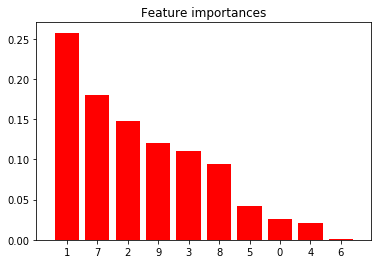

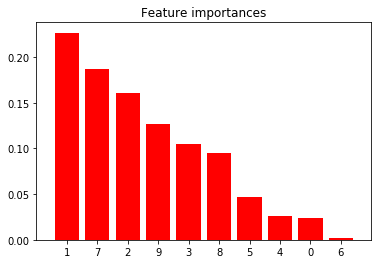

In [137]:
# Split-out validation dataset
col = len(master.columns) - 1
array = master.values   #numpy array
X = array[:,0:col]# first N columns
Y = array[:,col]  # SEPSIS column

print(master.columns.values)

validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

for clf in featureImportanceModels:
    clf.fit(X, Y)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [138]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.965155 (0.002644)
KNN: 0.964382 (0.002478)
CART: 0.931858 (0.003009)
NB: 0.945593 (0.011297)
RF: 0.964720 (0.002599)


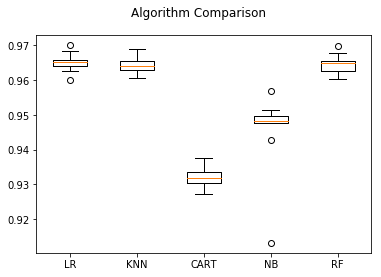

In [139]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

accuracy 0.9624721926685366
confusion Matrix [[9951    2]
 [ 386    0]]
precision [0.03733437 0.         1.        ]
recall [1. 0. 0.]
sensitivity 0.9997990555611374
specificity 0.0
stuff (array([0.00000000e+00, 2.00944439e-04, 1.00000000e+00]), array([0., 0., 1.]), array([2., 1., 0.]))


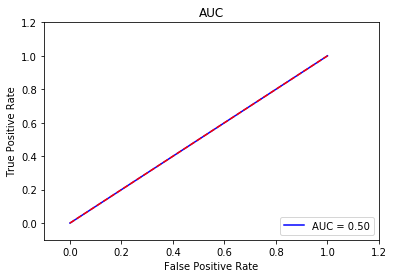

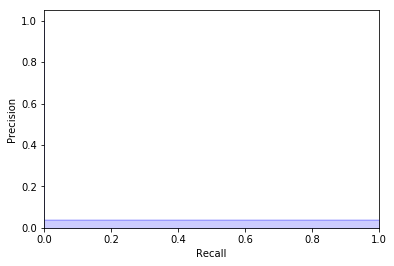

accuracy 0.961988586903956
confusion Matrix [[9943   10]
 [ 383    3]]
precision [0.03733437 0.23076923 1.        ]
recall [1.         0.00777202 0.        ]
sensitivity 0.9989952778056868
specificity 0.007772020725388601
stuff (array([0.        , 0.00100472, 1.        ]), array([0.        , 0.00777202, 1.        ]), array([2., 1., 0.]))


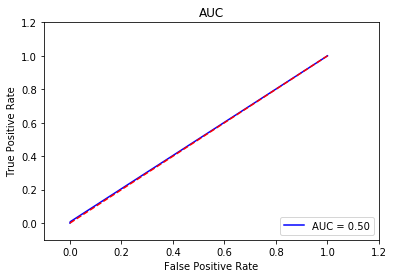

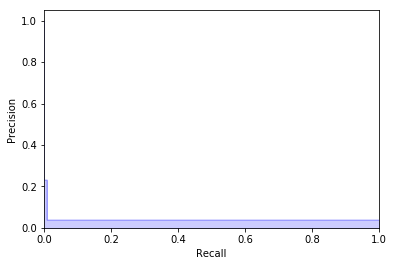

accuracy 0.9316181448882871
confusion Matrix [[9581  372]
 [ 335   51]]
precision [0.03733437 0.12056738 1.        ]
recall [1.         0.13212435 0.        ]
sensitivity 0.9626243343715463
specificity 0.13212435233160622
stuff (array([0.        , 0.03737567, 1.        ]), array([0.        , 0.13212435, 1.        ]), array([2., 1., 0.]))


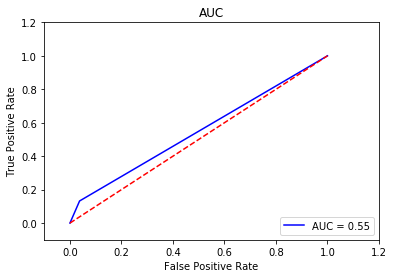

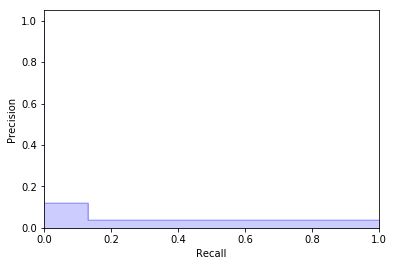

accuracy 0.9457394332140439
confusion Matrix [[9748  205]
 [ 356   30]]
precision [0.03733437 0.12765957 1.        ]
recall [1.         0.07772021 0.        ]
sensitivity 0.9794031950165779
specificity 0.07772020725388601
stuff (array([0.       , 0.0205968, 1.       ]), array([0.        , 0.07772021, 1.        ]), array([2., 1., 0.]))


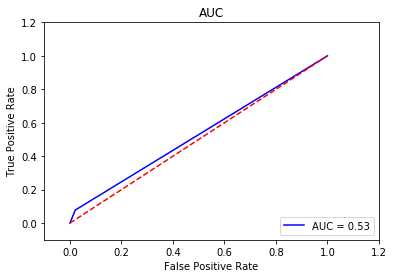

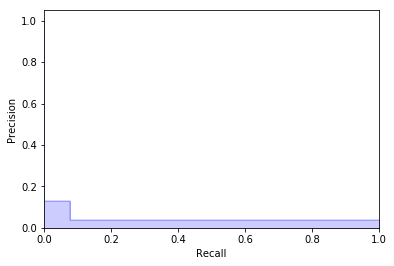

accuracy 0.9617951445981237
confusion Matrix [[9940   13]
 [ 382    4]]
precision [0.03733437 0.23529412 1.        ]
recall [1.         0.01036269 0.        ]
sensitivity 0.9986938611473928
specificity 0.010362694300518135
stuff (array([0.        , 0.00130614, 1.        ]), array([0.        , 0.01036269, 1.        ]), array([2., 1., 0.]))


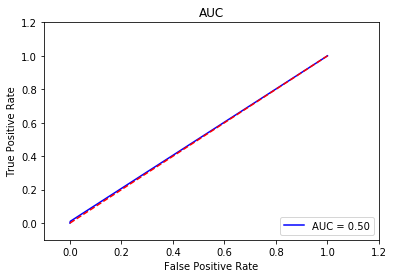

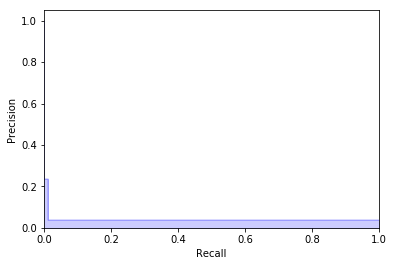

In [140]:
# Make predictions on validation dataset

messages = []
matrices = []
for name, model in models:
    model.fit(X_train, Y_train)
    prediction = model.predict(X_validation)
    
    accuracyScore = accuracy_score(Y_validation, prediction)
    confusionMatrix = confusion_matrix(Y_validation, prediction)
    classificationReport = classification_report(Y_validation, prediction)
    precision, recall, thresholds = precision_recall_curve(Y_validation, prediction)
    sensitivity = confusionMatrix[0, 0]/(confusionMatrix[0, 0]+confusionMatrix[0, 1])
    specificity = confusionMatrix[1, 1]/(confusionMatrix[1, 0]+confusionMatrix[1, 1])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_validation, prediction)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    #metrics.roc_curve(Y_validation, prediction)
    #auc = metrics.auc(confusionMatrix[0, 0], confusionMatrix[1, 1])
    
    print("accuracy", accuracyScore)
    print("confusion Matrix", confusionMatrix)
    print("precision", precision)
    print("recall", recall)
    print("sensitivity", sensitivity)
    print("specificity", specificity)
    print("stuff", roc_curve(Y_validation, prediction))
    plt.title('AUC')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()
    #matrices.append(confusionMatrix)
    
#print(confusionMatrix)
#print(messages)